In [1]:
import os
import tarfile
import urllib.request

DATASET_URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
data_dir = './data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)


dataset_path = os.path.join(data_dir, 'speech_commands_v0.02.tar.gz')
urllib.request.urlretrieve(DATASET_URL, dataset_path)


with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path=data_dir)

print("Dataset downloaded and extracted.")


Dataset downloaded and extracted.


In [3]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
from IPython import display

AUTOTUNE = tf.data.AUTOTUNE
print("Done")

Done


In [4]:
data_dir = pathlib.Path("./data")

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['testing_list.txt' 'zero' 'sheila' 'one' 'go' 'no' 'wow' 'forward' 'yes'
 'three' 'house' 'speech_commands_v0.02.tar.gz' 'LICENSE' 'six' 'stop'
 'two' 'bird' 'cat' 'learn' 'on' '.DS_Store' 'up' 'off' 'follow' 'right'
 '_background_noise_' 'left' 'happy' 'dog' 'five' 'nine' 'eight' 'tree'
 'seven' 'backward' 'down' 'visual' 'bed' 'validation_list.txt' 'marvin'
 'four']


In [5]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    label = get_label(file_path)
    return waveform, label


files = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
files = tf.random.shuffle(files)

print("Number of audio files:", len(files))


files_ds = tf.data.Dataset.from_tensor_slices(files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Number of audio files: 105835


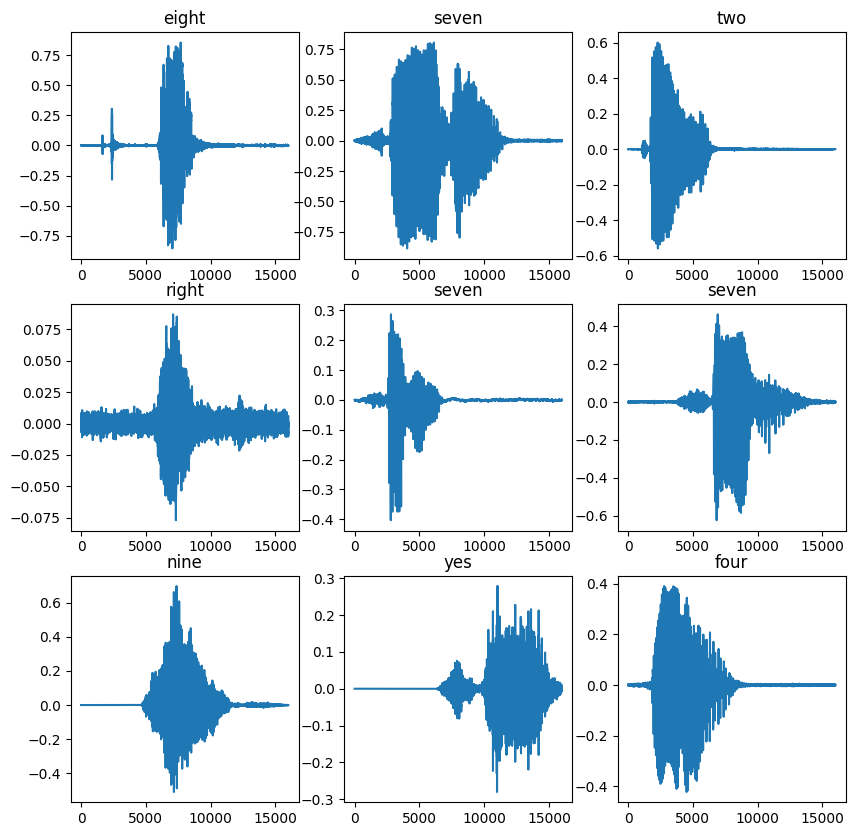

In [6]:
rows = 3
cols = 3
n = rows * cols
waveforms, labels = zip(*[(waveform.numpy(), label.numpy().decode('utf-8')) for waveform, label in waveform_ds.take(n)])

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (waveform, label) in enumerate(zip(waveforms, labels)):
    r = i // cols
    c = i % cols
    axes[r][c].plot(waveform)
    axes[r][c].set_title(label)

plt.show()

In [8]:
def get_spectrogram(waveform):

    waveform = tf.signal.frame(waveform, frame_length=16000, frame_step=16000, pad_end=True)
    waveform = tf.reshape(waveform, [-1])

    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)


    spectrogram = tf.image.resize(spectrogram, [161, 101])

    return spectrogram


def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
print("Done")

Done


In [9]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

total_files = len(files)
train_size = int(0.8 * total_files)
val_size = int(0.1 * total_files)
test_size = total_files - train_size - val_size

train_files = files[:train_size]
val_files = files[train_size:train_size+val_size]
test_files = files[train_size+val_size:]

print(f"Total files: {total_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Create datasets
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# Batch the datasets
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Use buffered prefetching
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)
# train_files = files[:int(len(files) * 0.8)]
# val_files = files[int(len(files) * 0.8):]
# test_files = files[int(len(files) * 0.2):]

# train_ds = preprocess_dataset(train_files)
# val_ds = preprocess_dataset(val_files)
# test_ds= preprocess_dataset(test_files)

# batch_size = 64
# train_ds = train_ds.batch(batch_size)
# val_ds = val_ds.batch(batch_size)
# test_ds = test_ds.batch(batch_size)


Total files: 105835
Train files: 84668
Validation files: 10583
Test files: 10584


In [10]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(161, 101, 1), batch_size=32),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(commands))

])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()

Input shape: (161, 101, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (32, 159, 99, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 79, 49, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 77, 47, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 38, 23, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 36, 21, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 18, 10, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 23040)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 128)                   │       2,949,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 41)                    │           5,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,047,209 (11.62 MB)

 Trainable params: 3,047,209 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
EPOCHS = 5
history = model.fit(
    train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    validation_data=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    epochs=EPOCHS
)

Epoch 1/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2938s 2s/step - accuracy: 0.6381 - loss: 1.3161 - val_accuracy: 0.8328 - val_loss: 0.5883
Epoch 2/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2822s 2s/step - accuracy: 0.8655 - loss: 0.4658 - val_accuracy: 0.8570 - val_loss: 0.5178
Epoch 3/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2799s 2s/step - accuracy: 0.9125 - loss: 0.2908 - val_accuracy: 0.8629 - val_loss: 0.5787
Epoch 4/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2798s 2s/step - accuracy: 0.9366 - loss: 0.2087 - val_accuracy: 0.8564 - val_loss: 0.6359
Epoch 5/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 2861s 2s/step - accuracy: 0.9503 - loss: 0.1606 - val_accuracy: 0.8650 - val_loss: 0.6505


In [13]:
model.save('speech_recognition_model.keras')

In [14]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.2f}")

166/166 ━━━━━━━━━━━━━━━━━━━━ 112s 671ms/step - accuracy: 0.8627 - loss: 0.6304
Test accuracy: 0.87


In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa

def preprocess_audio_file(file_path, target_sample_rate=16000, target_duration=1.0):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=None)

    # Resample if necessary
    if sample_rate != target_sample_rate:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)

    # Calculate target length
    target_length = int(target_sample_rate * target_duration)

    # Pad or truncate the audio to the target length
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]
        return audio

def predict_audio(data, model, commands):
    # Preprocess the audio file
    waveform = preprocess_audio_file(data)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, 0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(spectrogram)
    predicted_index = tf.argmax(predictions[0]).numpy()
    predicted_command = commands[predicted_index]
    confidence = tf.nn.softmax(predictions[0])[predicted_index].numpy()

    return predicted_command, confidence, waveform

def plot_prediction(waveform, predicted_command, confidence):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(waveform)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    spectrogram = get_spectrogram(waveform)
    plt.subplot(1, 2, 2)
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.suptitle(f'Predicted: {predicted_command} (Confidence: {confidence:.2f})')
    plt.tight_layout()
    plt.show()

